## 2. Programming section

#### Question 2.1

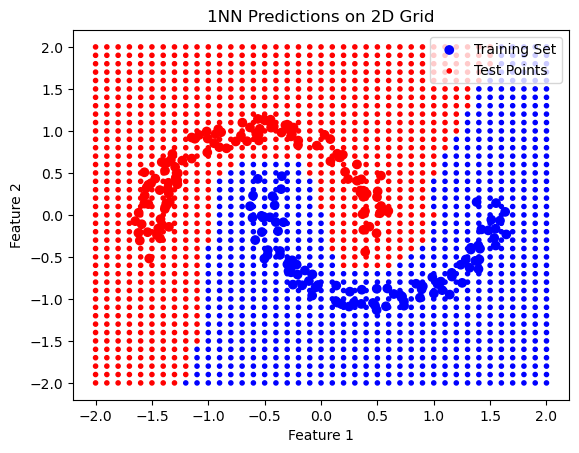

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load the training set
training_set = np.loadtxt("./hw3Data/D2z.txt")

# Generate a 2D grid of test points
x_values = np.arange(-2, 2.1, 0.1)
y_values = np.arange(-2, 2.1, 0.1)
test_points = np.array([[x, y] for x in x_values for y in y_values])

# X_train, X_test, y_train, y_test =

# Function to compute Euclidean distance between two points
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

# Function to predict the label of a test point using 1NN
def predict_1nn(test_point, training_set):
    distances = [euclidean_distance(test_point[:2], train_point[:2]) for train_point in training_set]
    nearest_neighbor_index = np.argmin(distances)
    return training_set[nearest_neighbor_index, 2]

# Make predictions for all test points
predictions = np.array([predict_1nn(test_point, training_set) for test_point in test_points])

# Visualize the training set and test points
plt.scatter(training_set[:, 0], training_set[:, 1], c=training_set[:, 2], marker='o', cmap='bwr', label='Training Set')
plt.scatter(test_points[:, 0], test_points[:, 1], c=predictions, marker='.', cmap='bwr', label='Test Points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('1NN Predictions on 2D Grid')
plt.legend()
plt.show()


## Question 2.2 and 2.4 (KNN from scratch)

- Change k values for k = [1,3,5,7,10] for Question 2.2 and 2.4

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def knn(train_data, test_data, k):
    predictions = []
    scores = []
    for test_row in tqdm(test_data):
        distances = []
        for train_row in train_data:
            distance = np.sqrt(np.sum((test_row[:-1] - train_row[:-1])**2))
            distances.append((train_row, distance))
        distances.sort(key=lambda x: x[1])
        neighbors = [x[0] for x in distances[:k]]
        counts = {}
        for neighbor in neighbors:
            label = neighbor[-1]
            if label in counts:
                counts[label] += 1
            else:
                counts[label] = 1
        predicted_label = max(counts, key=counts.get)
        predictions.append(predicted_label)
        scores.append(counts[1] / k if 1 in counts else 0)
    accuracy = np.mean(np.array(predictions) == np.array(test_data[:, -1]))
    return accuracy, predictions, scores

data = pd.read_csv('./hw3Data/emails.csv')
data = data[data.columns[1:]]
data_np = data.to_numpy()

k_values = [1, 3, 5, 7, 10]
num_folds = 5
fold_size = len(data) // num_folds

avg_metrics = {k: {"accuracy": [], "precision": [], "recall": []} for k in k_values}

for k in k_values:
    for fold in range(num_folds):
        test_start = fold * fold_size
        test_end = (fold + 1) * fold_size
        test_data = data_np[test_start:test_end]
        train_data = np.concatenate((data_np[:test_start], data_np[test_end:]))
        
        accuracy, predictions, _ = knn(train_data, test_data, k)
        precision = precision_score(test_data[:, -1], predictions)
        recall = recall_score(test_data[:, -1], predictions)
        
        print(accuracy, precision, recall)
        avg_metrics[k]["accuracy"].append(accuracy)
        avg_metrics[k]["precision"].append(precision)
        avg_metrics[k]["recall"].append(recall)

    print(f'k={k}:')
    print(f'  Average Accuracy: {np.mean(avg_metrics[k]["accuracy"]):.3f}')
    print(f'  Average Precision: {np.mean(avg_metrics[k]["precision"]):.3f}')
    print(f'  Average Recall: {np.mean(avg_metrics[k]["recall"]):.3f}\n')


## Question 2.3 (Logistic Regression from scratch)

In [10]:
import numpy as np
from tqdm import tqdm
import pandas as pd

def sigmoid(z):
    z = np.clip(z, -250, 250)
    return 1 / (1 + np.exp(-z))

def logistic_regression(X_train, y_train, learning_rate, epochs):
    m, n = X_train.shape
    weights = np.zeros(n)
    # bias = 0

    for epoch in tqdm(range(epochs)):
        z = np.dot(X_train, weights)
        prediction = sigmoid(z)

        gradient_weights = np.dot(X_train.T, (prediction - y_train))    
        # gradient_weights *= -1
        # gradient_bias = np.sum(prediction - y_train) / m

        weights -= learning_rate * gradient_weights

    return weights

def predict(X, weights):
    z = np.dot(X, weights)
    return sigmoid(z) >= 0.5

def k_fold_cross_validation(X, y, k=5):
    m = len(y)
    fold_size = m // k
    indices = np.arange(m)
    np.random.shuffle(indices)

    accuracies = []
    precisions = []
    recalls = []

    for i in range(k):
        test_indices = indices[i*fold_size:(i+1)*fold_size]
        train_indices = np.setdiff1d(indices, test_indices)

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        weights  = logistic_regression(X_train, y_train, learning_rate=0.01, epochs=1000)
        y_pred = predict(X_test, weights)

        accuracy = np.mean(y_pred == y_test)
        precision = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_pred == 1)
        recall = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_test == 1)

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)

    return accuracies, precisions, recalls

# Load the data
data = pd.read_csv('./hw3Data/emails.csv')
X = data.iloc[:, 1:-1].values
y = data['Prediction'].values

# Normalize the data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Add intercept term (bias) to X
X = np.hstack((np.ones((X.shape[0], 1)), X))

# 5-fold cross-validation
accuracies, precisions, recalls = k_fold_cross_validation(X, y, k=5)
print(f"Accuracies: {accuracies}")
print(f"Precisions: {precisions}")
print(f"Recalls: {recalls}")
print(f"Average Accuracy: {np.mean(accuracies)}")
print(f"Average Precision: {np.mean(precisions)}")
print(f"Average Recall: {np.mean(recalls)}")


100%|██████████| 1000/1000 [00:06<00:00, 160.64it/s]

Accuracies: [0.965, 0.968, 0.984, 0.97, 0.971]
Precisions: [0.9102564102564102, 0.9134948096885813, 0.9591836734693877, 0.9331103678929766, 0.940251572327044]
Recalls: [0.9759450171821306, 0.974169741697417, 0.986013986013986, 0.9653979238754326, 0.9676375404530745]
Average Accuracy: 0.9715999999999999
Average Precision: 0.93125936672688
Average Recall: 0.973832841844408


### ROC calculation for Logistic regression
- Calculatiions for ROC curve for Q2.5

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Read the dataset
data = pd.read_csv('./hw3Data/emails.csv')

# Sigmoid function
def sigmoid(z):
    z = np.clip(z, -250, 250)
    return 1 / (1 + np.exp(-z))

# Logistic regression function
def logistic_regression(X, y, lr=0.01, epochs=1000):
    w = np.zeros(X.shape[1])
    m = len(y)
    
    for epoch in tqdm(range(epochs)):
        z = np.dot(X, w)
        h = sigmoid(z)
        gradient = np.dot(X.T, (h - y))/m
        w -= lr * gradient
        
    return w

# Predict function
def predict_probs(X, weights):
    return sigmoid(np.dot(X, weights))

# Splitting data into 80% train and 20% test

X_train = data.iloc[int(data.shape[0] * 0.2):, 1:-1]
y_train = data.iloc[int(data.shape[0] * 0.2):, -1]
X_test = data.iloc[:int(data.shape[0] * 0.2), 1:-1]
y_test = data.iloc[:int(data.shape[0] * 0.2), -1]

# Add bias column
X_train = np.column_stack([np.ones(X_train.shape[0]), X_train])
X_test = np.column_stack([np.ones(X_test.shape[0]), X_test])

weights = logistic_regression(X_train, y_train, epochs=1000)

# ROC Curve calculation
tprs = []
fprs = []
thresholds = np.linspace(0, 1, 100)
y_pred_probs = predict_probs(X_test, weights)

for thresh in thresholds:
    y_pred = y_pred_probs > thresh
    tp = np.sum((y_test == 1) & (y_pred == 1))
    fp = np.sum((y_test == 0) & (y_pred == 1))
    fn = np.sum((y_test == 1) & (y_pred == 0))
    tn = np.sum((y_test == 0) & (y_pred == 0))
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    tprs.append(tpr)
    fprs.append(fpr)


100%|██████████| 1000/1000 [00:06<00:00, 154.78it/s]


### Question 2.4
- Plot data from preious calculations (Q2.2)

Text(0, 0.5, 'Average Accuracy')

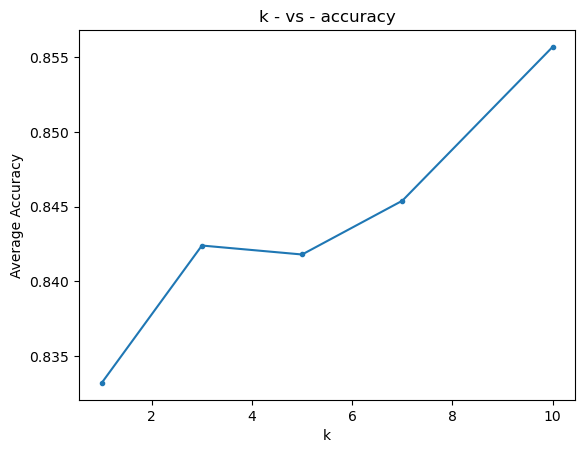

In [28]:
import numpy as np

k1 = np.mean([0.825,0.853,0.862,0.851,0.775])   #0.8332
k3 = np.mean([0.847,0.851,0.860,0.880,0.774])   #0.8424
k5 = np.mean([0.838,0.850,0.873,0.869,0.779])   #0.8418
k7 = np.mean([0.838,0.862,0.875,0.874,0.778])   #0.8454
k10 = np.mean([0.858,0.875,0.883,0.890,0.792])   #0.8557

x = [1,3,5,7,10]
y = [0.8332, 0.8424, 0.8418, 0.8454, 0.8557]
plt.plot(x,y, marker = '.')
plt.title("k - vs - accuracy")
plt.xlabel('k')
plt.ylabel('Average Accuracy')


## Question 2.5
- Plotting ROC of KNN vs Logistic Regression

100%|██████████| 1000/1000 [04:03<00:00,  4.11it/s]


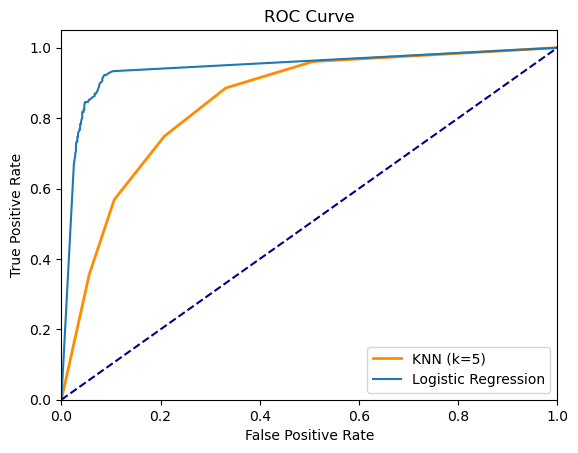

Accuracy: 0.78
Precision: 0.61
Recall: 0.75


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the k-nearest neighbors function
def knn(train_data, test_data, k):
    predictions = []
    scores = []

    for test_row in tqdm(test_data):
        distances = []
        for train_row in train_data:
            distance = np.sqrt(np.sum((test_row[:-1] - train_row[:-1])**2))
            distances.append((train_row, distance))

        distances.sort(key=lambda x: x[1])
        neighbors = [x[0] for x in distances[:k]]
        
        counts = {}
        for neighbor in neighbors:
            label = neighbor[-1]
            if label in counts:
                counts[label] += 1
            else:
                counts[label] = 1
        
        predicted_label = max(counts, key=counts.get)
        predictions.append(predicted_label)
        scores.append(counts[1] / k if 1 in counts else 0)

    correct = sum(1 for i in range(len(test_data)) if test_data[i][-1] == predictions[i])
    accuracy = correct / float(len(test_data))
    
    return accuracy, predictions, scores

# Load your dataset
data = pd.read_csv('./hw3Data/emails.csv')
data = data[data.columns[1:]]

# 1-Fold Validation with k=5
k = 5
test_set = data.iloc[4000:5000]
train_set = data.drop(test_set.index)

accuracy, predictions, scores = knn(train_set.values, test_set.values, k)

# ROC curve
fpr, tpr, _ = roc_curve(test_set.iloc[:, -1].values, scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='KNN (k=5)')
plt.plot(fprs, tprs, label='Logistic Regression')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Precision and Recall
precision = precision_score(test_set.iloc[:, -1].values, predictions)
recall = recall_score(test_set.iloc[:, -1].values, predictions)

# print(f'Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}')
